In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.7.2 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


In [3]:
adata_concat = sc.read_h5ad("./inputs/adata_full.h5ad")
adata_concat.obs = pd.read_csv("./inputs/metad_full.csv", index_col=0)

In [4]:
#Normalize gene counts
sc.pp.normalize_total(adata_concat, target_sum=1e6)

# Logarithmize the data.
sc.pp.log1p(adata_concat)

#Store raw data, for finding markers in each cluster and other analysis
adata_concat.raw = adata_concat

normalizing counts per cell
    finished (0:00:00)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


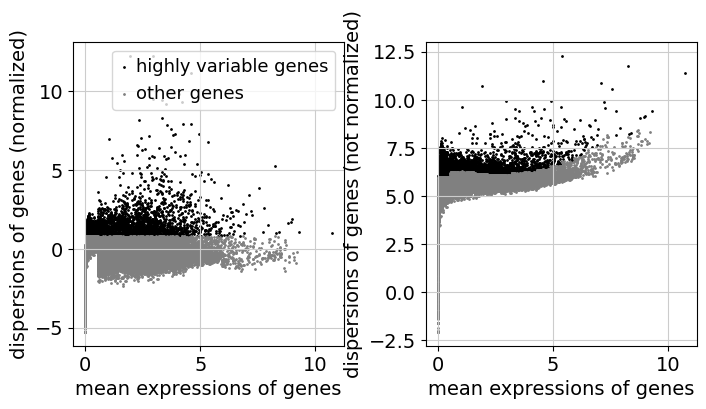

Highly variable genes: 3000


In [5]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata_concat, n_top_genes=3000)
sc.pl.highly_variable_genes(adata_concat)

print("Highly variable genes: %d"%sum(adata_concat.var.highly_variable))
var_genes_all = adata_concat.var.highly_variable
adata_concat = adata_concat[:,var_genes_all]

In [6]:
sc.pp.scale(adata_concat, max_value=10)

/home/unix/sjohri/valab_sjohri/envs/beanie_revisions/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:13)


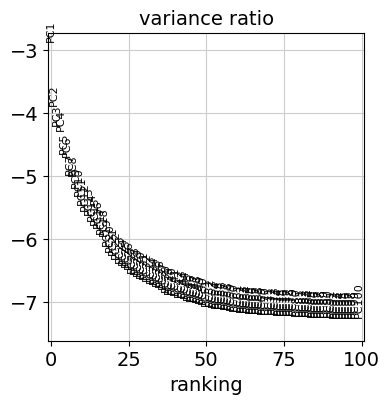

In [7]:
# Set seed
import random
initialization = 3120
random.seed(initialization)

sc.pp.pca(adata_concat, random_state=initialization, svd_solver='arpack', n_comps=100)
sc.pl.pca_variance_ratio(adata_concat, n_pcs= 100, log=True, show = True)
# sc.pl.pca_overview(adata_concat,color="n_genes")

In [8]:
sc.external.pp.harmony_integrate(adata_concat, key=["sample_id"],
                                 random_state=initialization, max_iter_harmony=50)
adata_concat.obsm['X_pca'] = adata_concat.obsm['X_pca_harmony']

2024-11-13 17:36:32,181 - harmonypy - INFO - Iteration 1 of 50
2024-11-13 17:36:40,364 - harmonypy - INFO - Iteration 2 of 50
2024-11-13 17:36:48,557 - harmonypy - INFO - Converged after 2 iterations


In [9]:
npc = 100
sc.pp.neighbors(adata_concat, random_state=initialization, n_neighbors=40, n_pcs=npc)
sc.tl.umap(adata_concat, random_state=initialization, min_dist=0.2)

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
... storing 'sample_id' as categorical
... storing 'group_id' as categorical


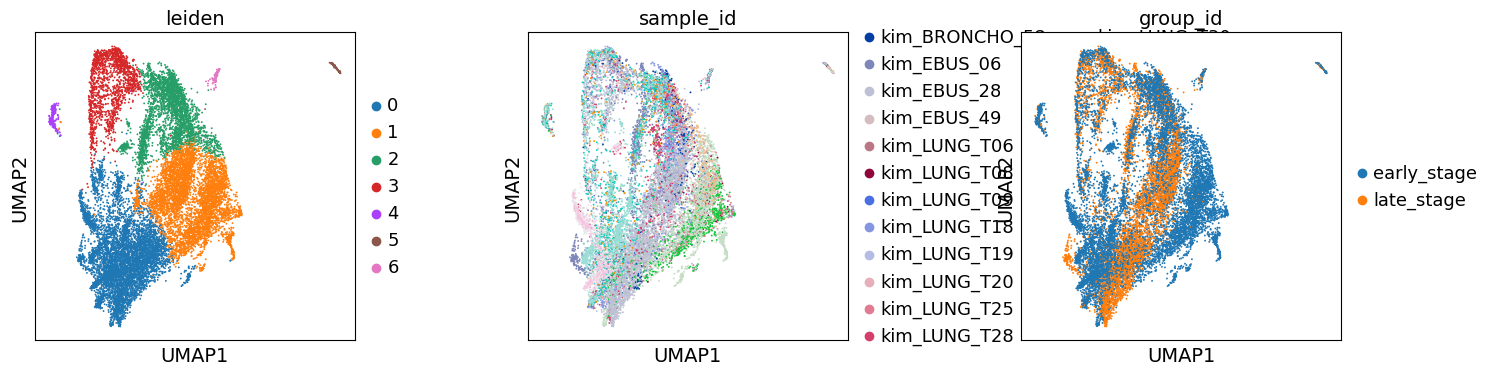

In [10]:
sc.tl.leiden(adata_concat, random_state=initialization, resolution=0.25)
sc.pl.umap(adata_concat, color=['leiden', 'sample_id', 'group_id'], wspace=0.4, show = True)

In [11]:
sc.tl.rank_genes_groups(adata_concat, groupby='leiden', method='logreg')

ranking genes
/home/unix/sjohri/valab_sjohri/envs/beanie_revisions/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:55)


In [12]:
adata_concat.write_h5ad("./inputs/adata_full_clustered.h5ad")

In [13]:
adata_concat_backup = sc.read_h5ad("./inputs/adata_full.h5ad")
adata_concat_backup.obs = pd.read_csv("./inputs/metad_full.csv", index_col=0)

In [15]:
dmap_brca = pkl.load(open("luad_sampleid_map.pkl","rb"))
adata_concat.obs.sample_id = adata_concat.obs.sample_id.map(dmap_brca)

cluster_ids = sorted(set(adata_concat.obs.leiden))
for idx in cluster_ids:
    # save non log-normalized counts (set normalized=False in BEANIE)
    adata_concat_backup[adata_concat[adata_concat.obs.leiden==idx].obs.index,].write_h5ad(f"./inputs/ts{int(idx)+1}_adata.h5ad")
    adata_concat[adata_concat.obs.leiden==idx].obs[["sample_id","group_id"]].to_csv(f"./inputs/ts{int(idx)+1}_metad.csv")

/home/unix/sjohri/valab_sjohri/envs/beanie_revisions/lib/python3.6/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample